In [1]:
!jupyter nbextension enable splitcell/splitcell
!jupyter nbextension enable rise/main
%matplotlib inline

Enabling notebook extension splitcell/splitcell...
      - Validating: OK
Enabling notebook extension rise/main...
      - Validating: OK



# Tutorial: Lorentz Boost Networks (LBN)

### Physics-Inspired Autonomous Feature Engineering ([arXiv:1812.09722](https://arxiv.org/abs/1812.09722))

<br>

Martin Erdmann, Yannik Rath, **Marcel Rieger**

<center><img style="height: 300px;" src="https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Flbn%2Fimages&files=front.png" /></center>

### Outline of this tutorial

1. [LBN introduction](#LBN-introduction)

2. [Application: Classification task](#Application:-Classification-task)

3. [LBN introspection](#LBN-introspection)

4. [Open part](#Open-part)

<center><img src="https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Flbn%2Fimages&files=feynman_ttH.png" /></center>

### LBN introduction

#### Feature engineering in HEP

<center><img style="height: 300px;" src="https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Flbn%2Fimages&files=fe1.png" /></center>

#### Feature engineering in HEP

<center><img style="height: 300px;" src="https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Flbn%2Fimages&files=fe2.png" /></center>

#### Feature engineering in HEP

<center><img style="height: 300px;" src="https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Flbn%2Fimages&files=fe3.png" /></center>

**Observations**
1. Physicists’ crafted high-level features might not exploit all information
2. In practice, it is hard for “standard” DNNs (FCNs) to learn complex features

#### Feature engineering in HEP

- Situation similar to transition **FCNs** &rarr; **CNNs**
  - Images contain information in translation invariant adjacency <br />
  → *Exploit information by changing the network structure!*
  
<center><img style="height: 300px;" src="https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Flbn%2Fimages&files=transl.png" /></center>

**→ Encode first-principles of domain (physics) into network structure**

#### LBN architecture

<center><img style="height: 480px;" src="https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Flbn%2Fimages&files=lbn_architecture.png" /></center>

#### LBN architecture

<center><img style="height: 340px;" src="https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Flbn%2Fimages&files=lbn_architecture.png" /></center>

- Only *2 M N* trainable parameters in LBN (usually O(1k))
- Different boosting configurations possible (pairwise, product, etc)
- Generic feature projections, **not tailored** to use case

#### LBN architecture: Boosting

- Lorentz transformation with boost matrix

<center><img style="height: 240px;" src="https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Flbn%2Fimages&files=lambda.png" /></center>

- Vectorized formulation to run efficiently on GPUs
 
<center><img style="height: 180px;" src="https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Flbn%2Fimages&files=lambda_vec.png" /></center>

#### LBN architecture: Feature engineering

<center><img style="height: 270px;" src="https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Flbn%2Fimages&files=lbn_architecture.png" /></center>

- Extract **generic** features from boosted particles
    1. Simple features, such as $E$, $m$, $p_T$, $\eta$, $\phi$
    2. Pairwise features, such as $\cos(\measuredangle)$ between all pairs

- More features possible, but **not necessary**

### Application: Classification task

In the following, we want distinguish $t\bar{t}H (H \rightarrow b\bar{b})$ and $t\bar{t} + b\bar{b}$ <br />
**using only low-level features**, i.e., four-vectors

<center><img style="height: 350px;" src="https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Flbn%2Fimages&files=feynman_ttH.png" /></center>

<center><img style="height: 350px;" src="https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Flbn%2Fimages&files=feynman_ttbb.png" /></center>

#### The dataset

- Events generated with Pythia <br /> ($13$ $TeV$)
- Detector simulation using Delphes (CMS configuration)
- ~800k (~200k) events for training (validation)
- $t\bar{t}H$ / $t\bar{t}b\bar{b}$ $\approx$ 50/50 %
- Four-vectors ($E$, $p_{x}$, $p_{y}$, $p_{z}$) of <br /> 6 jets + ch. lepton + neutrino
- Labels: 0 for $t\bar{t}b\bar{b}$, 1 for $t\bar{t}H$

<center><img style="height: 320px;" src="https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Flbn%2Fimages&files=feynman_ttH.png" /></center>

- Object naming:
  - "bhad", "blep"
  - "lj1", "lj2"
  - "bj1", "bj2"
  - "lep", "nu"

#### Remark: Jet sorting

<center><img style="height: 380px;" src="https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Flbn%2Fimages&files=sorting.png" /></center>

- **Option 1**: Use generator information (only for LBN introspection) &larr;
- **Option 2**: Sorted by $p_T$ ("real-life" scenario)

#### Inspect the data

In [2]:
import os

import numpy as np
import tensorflow as tf
from lbn import LBN, LBNLayer

import tutorial as tut
import plotting as plt

print("TF version: {}".format(tf.__version__))

eos access: ✗
TF version: 2.0.0-alpha0


In [3]:
# load data using the tut.load_lbn_data helper (for pt-sorted jets, use sorting="pt")
data_train = tut.load_lbn_data("train", sorting="gen")
data_valid = tut.load_lbn_data("valid", sorting="gen")

# extract vectors
vectors_train = data_train["features"]
vectors_valid = data_valid["features"]

# extract labels and apply one-hot encoding
labels_train = tf.keras.utils.to_categorical(data_train["labels"], num_classes=2)
labels_valid = tf.keras.utils.to_categorical(data_valid["labels"], num_classes=2)

In [4]:
# print shapes
print("vectors_train shape: {}".format(vectors_train.shape))
print("vectors_valid shape: {}".format(vectors_valid.shape))

print("labels_train shape : {}".format(labels_train.shape))
print("labels_valid shape : {}".format(labels_valid.shape))

vectors_train shape: (828269, 32)
vectors_valid shape: (207067, 32)
labels_train shape : (828269, 2)
labels_valid shape : (207067, 2)


#### Plot some low-level features

In [5]:
# store feature column indices in locals
import itertools
components = ["E", "px", "py", "pz"]
particle_names = ["bhad", "blep", "lj1", "lj2", "bj1", "bj2", "lep", "nu"]
for i, (n, c) in enumerate(itertools.product(particle_names, components)):
    locals()["{}_{}".format(c.upper(), n.upper())] = i

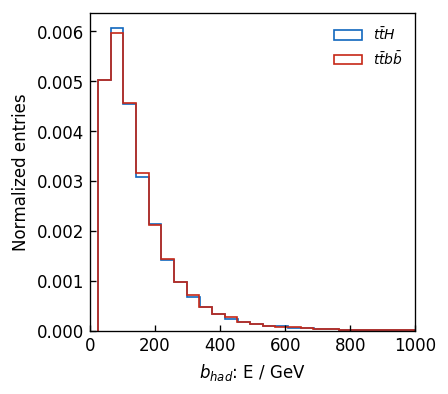

In [6]:
# plot the energy of the jet "bhad"
E_bhad = vectors_valid[:, E_BHAD]



fig, ax = plt.plot_lbn_feature(
    E_bhad, labels_valid,
    limits=(0, 1000),
    xlabel="$b_{had}$: E / GeV")

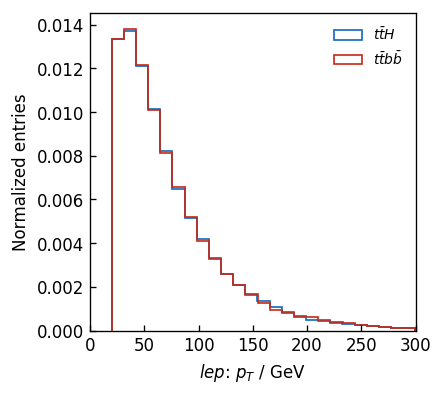

In [7]:
# plot the pT of the lepton
px_lep = vectors_valid[:, PX_LEP]
py_lep = vectors_valid[:, PY_LEP]
pt_lep = (px_lep**2 + py_lep**2)**0.5

fig, ax = plt.plot_lbn_feature(
    pt_lep, labels_valid,
    limits=(0, 300),
    xlabel="$lep$: $p_{T}$ / GeV")

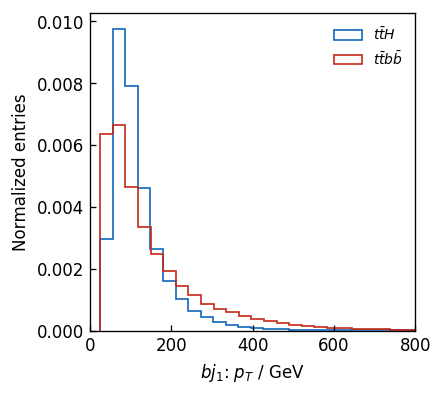

In [8]:
# plot the pT of the jet "bj1"
px_bj1 = vectors_valid[:, PX_BJ1]
py_bj1 = vectors_valid[:, PY_BJ1]
pt_bj1 = (px_bj1**2 + py_bj1**2)**0.5

fig, ax = plt.plot_lbn_feature(
    pt_bj1, labels_valid,
    limits=(0, 800),
    xlabel="$bj_{1}$: $p_{T}$ / GeV")

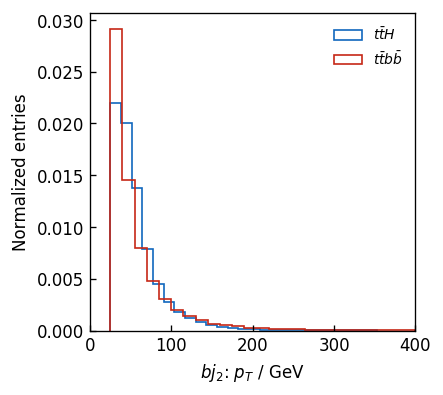

In [9]:
# plot the pT of the jet "bj2"
px_bj2 = vectors_valid[:, PX_BJ2]
py_bj2 = vectors_valid[:, PY_BJ2]
pt_bj2 = (px_bj2**2 + py_bj2**2)**0.5

fig, ax = plt.plot_lbn_feature(
    pt_bj2, labels_valid,
    limits=(0, 400),
    xlabel="$bj_{2}$: $p_{T}$ / GeV")

Expect to see differences caused by the two b-jets from $H$ / $g \rightarrow b\bar{b}$

#### Model definition

In [10]:
# create the LBN layer
# possible boost modes are "pairs" and "product"
features = ["E", "pt", "eta", "phi", "m"]
lbn_layer = LBNLayer(n_particles=13, boost_mode="pairs", features=features)

l2_reg = tf.keras.regularizers.l2(1e-4)
dense_kwargs = dict(
    activation="selu",
    kernel_initializer=tf.keras.initializers.lecun_normal(),
    kernel_regularizer=l2_reg,
)

model = tf.keras.models.Sequential()
model.add(lbn_layer)
model.add(tf.keras.layers.BatchNormalization(axis=1))
model.add(tf.keras.layers.Dense(1024, **dense_kwargs))
model.add(tf.keras.layers.Dense(512, **dense_kwargs))
model.add(tf.keras.layers.Dense(256, **dense_kwargs))
model.add(tf.keras.layers.Dense(128, **dense_kwargs))
model.add(tf.keras.layers.Dense(2, activation="softmax", kernel_regularizer=l2_reg))

# define metrics to monitor during training
metrics = [
    tf.keras.metrics.categorical_accuracy,
    tf.keras.metrics.AUC(),
]

# select the optimizer
optimizer = tf.keras.optimizers.Adam(lr=1e-4)

# setup the model for training
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=metrics)

#### Helpers: Model fitting and loading

In [11]:
def fit_model(model, name, data=None, validation_data=None, epochs=10, batch_size=512):
    model_dir = os.path.join(tut.data_dir, "lbn", "models", name)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    fit_callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(model_dir, name),
            save_best_only=True,
            save_weights_only=True,
            monitor="val_auc",
            mode="max",
        ),
    ]

    if data is None:
        data = (vectors_train, labels_train)
    if validation_data is None:
        validation_data = (vectors_valid, labels_valid)

    model.fit(data[0], data[1],
        validation_data=validation_data,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=fit_callbacks,
    )

In [12]:
def load_model(model, name):
    local_dir = tut.get_file(os.path.join("lbn", "models", name), is_dir=True)
    print("loading model from {}".format(local_dir))
    model.load_weights(os.path.join(local_dir, name))

#### Fit or load the model

In [13]:
# set this flag to True in case you want to train the network
do_fit = False

if do_fit:
    # run a new fit for 1 epoch, store the weights as "lbn_v1"
    fit_model(model, "lbn_v1", epochs=1)
else:
    load_model(model, "lbn_pretrained")
    
# make a prediction for the first 5 validation events
print(model.predict(vectors_valid[:5]))

# print the model summary
model.summary()

loading model from /tutorial/data/lbn/models/lbn_pretrained
[[0.07558268 0.92441726]
 [0.36667264 0.6333273 ]
 [0.38706946 0.61293054]
 [0.80215394 0.19784614]
 [0.5337521  0.4662479 ]]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lbn_layer (LBNLayer)         multiple                  208       
_________________________________________________________________
batch_normalization_v2 (Batc multiple                  260       
_________________________________________________________________
dense (Dense)                multiple                  67584     
_________________________________________________________________
dense_1 (Dense)              multiple                  524800    
_________________________________________________________________
dense_2 (Dense)              multiple                  131328    
_________________________________________________________________
de

#### Check training results

In [14]:
# run the prediction on the full validation set
pred_valid = model.predict(vectors_valid)

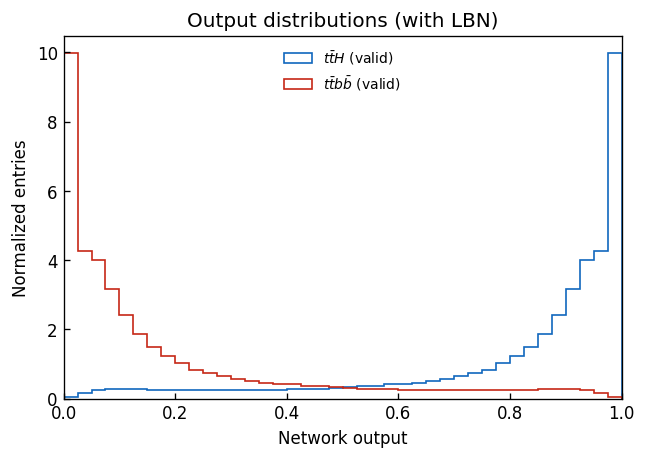

In [15]:
# plot the output distribution
fig, ax = plt.plot_lbn_outputs("Output distributions (with LBN)",
    pred_valid, labels_valid)

In [16]:
# compute the ROC AUC score
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(labels_valid, pred_valid)
print("ROC AUC: {:.3f}".format(auc))

ROC AUC: 0.941


### Performance comparison LBN+DNN vs. DNN-only

In [17]:
# define the DNN-only model
l2_reg = tf.keras.regularizers.l2(1e-4)
dense_kwargs = dict(
    activation="selu",
    kernel_initializer=tf.keras.initializers.lecun_normal(),
    kernel_regularizer=l2_reg,
)

model_dnn = tf.keras.models.Sequential()
model_dnn.add(tf.keras.layers.BatchNormalization(axis=1))
model_dnn.add(tf.keras.layers.Dense(1024, **dense_kwargs))
model_dnn.add(tf.keras.layers.Dense(512, **dense_kwargs))
model_dnn.add(tf.keras.layers.Dense(256, **dense_kwargs))
model_dnn.add(tf.keras.layers.Dense(128, **dense_kwargs))
model_dnn.add(tf.keras.layers.Dense(2, activation="softmax", kernel_regularizer=l2_reg))

# define metrics to monitor during training
metrics = [
    tf.keras.metrics.categorical_accuracy,
    tf.keras.metrics.AUC(),
]

# select the optimizer
optimizer = tf.keras.optimizers.Adam(lr=1e-4)

# setup the model for training
model_dnn.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=metrics)

#### Fit or load the model

In [18]:
# set this flag to True in case you want to train the network
do_fit = False

if do_fit:
    # run a new fit for 1 epoch, store the weights as "dnn_v1"
    fit_model(model_dnn, "dnn_v1", epochs=1)
else:
    # load the pretrained DNN-only model
    load_model(model_dnn, "dnn_pretrained")
    
# make a test prediction for the first 5 validation events
model_dnn.predict(vectors_valid[:5])

loading model from /tutorial/data/lbn/models/dnn_pretrained


array([[0.06204647, 0.93795353],
       [0.11479806, 0.88520193],
       [0.50971425, 0.4902858 ],
       [0.24645525, 0.75354475],
       [0.33288956, 0.6671105 ]], dtype=float32)

In [19]:
# run the prediction on the full validation set
pred_valid_dnn = model_dnn.predict(vectors_valid)

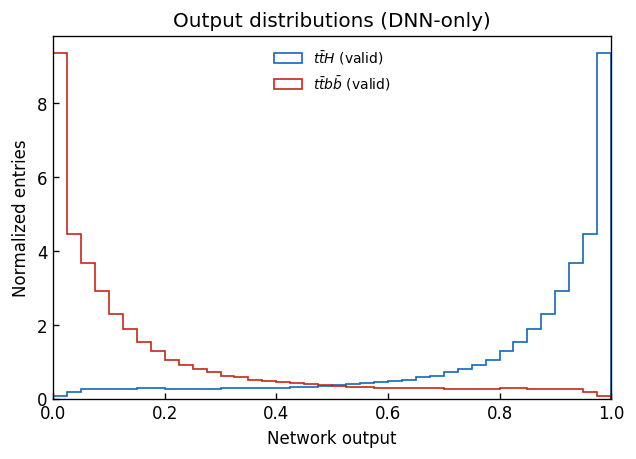

In [20]:
# plot the output distribution
fix, ax = plt.plot_lbn_outputs("Output distributions (DNN-only)",
    pred_valid_dnn, labels_valid)

In [21]:
# compute the ROC AUC score
auc = roc_auc_score(labels_valid, pred_valid_dnn)
print("ROC AUC: {:.3f}".format(auc))

ROC AUC: 0.933


#### ROC curves

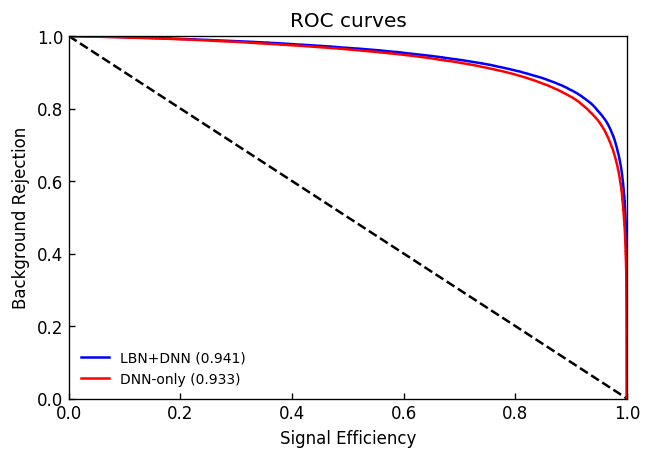

In [22]:
# plot the ROC cuves, i.e., background rejection vs signal efficiency
fig, ax = plt.plot_lbn_rocs(
    dict(label="LBN+DNN", labels=labels_valid, prediction=pred_valid, color="blue"),
    dict(label="DNN-only", labels=labels_valid, prediction=pred_valid_dnn, color="red"),
)

#### The full picture

<center><img style="height: 380px;" src="https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Flbn%2Fimages&files=roc_comparison_gen.png" /></center>

<center><img style="height: 380px;" src="https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Flbn%2Fimages&files=roc_comparison_pt.png" /></center>

- Plots from [arXiv:1812.09722](https://arxiv.org/abs/1812.09722)
- High-level variables from *JHEP* **03** (2019) 026, [arXiv:1804.03682](https://arxiv.org/abs/1804.03682)

#### LBN introspection

<center><img style="height: 330px;" src="https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Flbn%2Fimages&files=lbn_architecture.png" /></center>

1. Investigate particle and restframe weights (for generator ordered jets)
2. Study created features 

#### Weights in combination layers

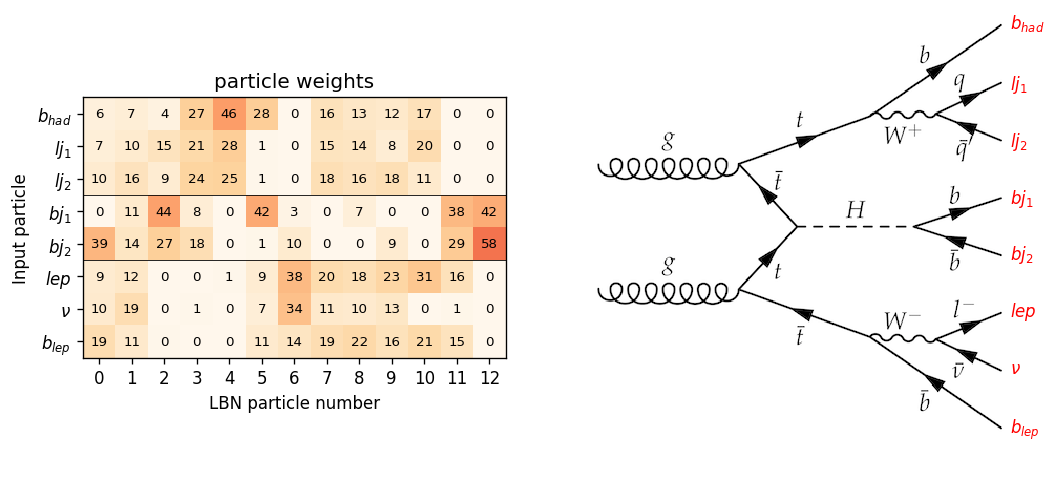

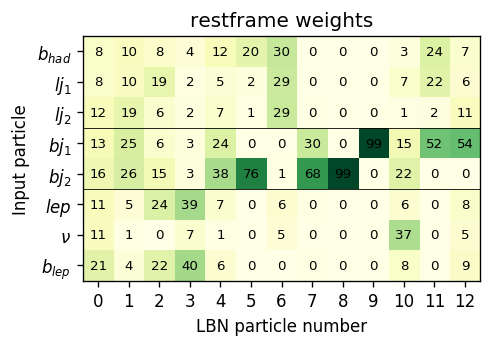

In [23]:
particle_weights = np.abs(lbn_layer.particle_weights.numpy())
fig, ax = plt.plot_lbn_weights(particle_weights, "particle", cmap="OrRd")

restframe_weights = np.abs(lbn_layer.restframe_weights.numpy())
fig, ax = plt.plot_lbn_weights(restframe_weights, "restframe", cmap="YlGn", hide_feynman=True)

#### Evolution of weights over time

![](https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Flbn%2Fimages&files=particle_weights_evo.gif)

![](https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Flbn%2Fimages&files=restframe_weights_evo.gif)

#### Created features

In [24]:
# store feature indices in locals (such as E_0, M_12, PX_5, ...)
for i, (n, m) in enumerate(itertools.product(lbn_layer.feature_names, list(range(lbn_layer.lbn.n_out)))):
    locals()["{}_{}".format(n.upper(), m)] = i

In [25]:
# get the features produced by the LBN
features = plt.get_lbn_features(lbn_layer, vectors_valid)

# the variables to plot are accessible via flags, such as E_0, M_12, PX_5, ...

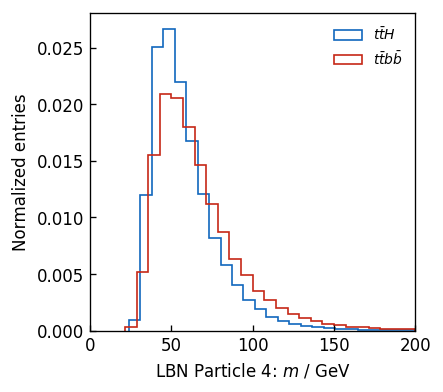

In [26]:
# plot the mass of the 4th particle
fig, ax = plt.plot_lbn_feature(
    features[:, M_4], labels_valid,
    limits=(0, 200),
    xlabel="LBN Particle 4: $m$ / GeV")

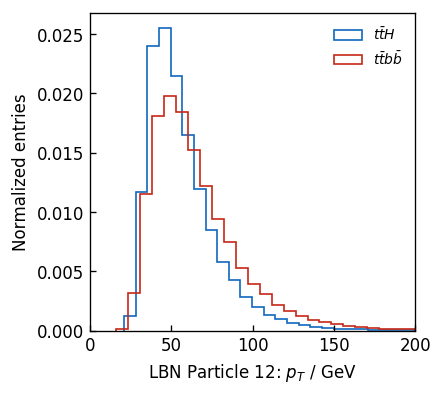

In [27]:
# plot the mass of the 12th particle
fig, ax = plt.plot_lbn_feature(
    features[:, M_12], labels_valid,
    limits=(0, 200),
    xlabel="LBN Particle 12: $p_T$ / GeV")

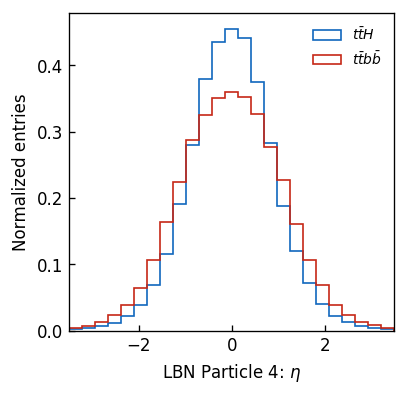

In [28]:
# plot the pseudorapidity of the 4th particle
fig, ax = plt.plot_lbn_feature(
    features[:, ETA_4], labels_valid,
    limits=(-3.5, 3.5),
    xlabel=r"LBN Particle 4: $\eta$")

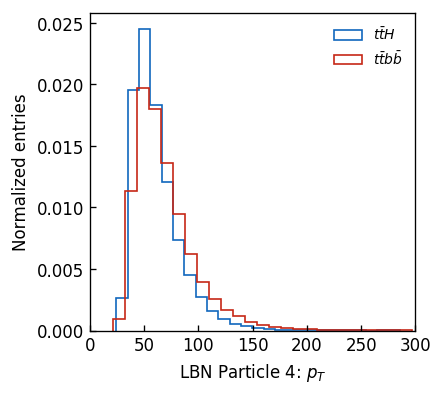

In [29]:
# plot the pT of the 4th particle
fig, ax = plt.plot_lbn_feature(
    features[:, E_4], labels_valid,
    limits=(0, 300),
    xlabel=r"LBN Particle 4: $p_{T}$")

### Open part

- Time for questions


<center><img style="height: 330px;" src="https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Flbn%2Fimages&files=roc_comparison_pt.png" /></center>

**Suggestions for remaining time**

Repeat the training for $p_{T}$ sorted data <br />
e.g. LBN+DNN (low-level) vs DNN-only (high-level)

#### Some hints

load data with $p_{T}$ sorted jets for both low- and high-level data

In [ ]:
# load data using the tut.load_lbn_data helper (for pt-sorted jets, use sorting="pt")
data_low = tut.load_lbn_data("train", sorting="pt", level="low")
data_high = tut.load_lbn_data("train", sorting="pt", level="high")

# extract low-level vectors
vectors_low = data_train["features"]

# extract high-level variables
features_high = data_train["features"]

# extract labels and apply one-hot encoding
labels_low = tf.keras.utils.to_categorical(data_low_["labels"], num_classes=2)
labels_high = tf.keras.utils.to_categorical(data_high["labels"], num_classes=2)

TODO: define the two models (see above for examples)

In [ ]:
# define the models here
# you should name them model_lbn_low and model_dnn_high

train the models (assuming the names are `model_lbn_low` and `model_dnn_high`)

In [ ]:
fit_model(model_lbn_low, "lbn_low_v1", data=(vectors_low, labels_low), epochs=1)
fit_model(model_dnn_high, "dnn_high_v1", data=(features_high, labels_high), epochs=1)
    
# make a prediction for the first 5 validation events
print("LBN (low-level) prediction : ...TODO")
print("DNN (high-level) prediction: ...TODO")

run the prediction (we are using the training set here ...)

In [ ]:
pred_lbn_low = model_lbn_low.predict(vectors_low)
pred_dnn_high = model_dnn_high.predict(features_high)

draw the ROC curves

In [ ]:
# plot the ROC cuves, i.e., background rejection vs signal efficiency
fig, ax = plt.plot_lbn_rocs(
    dict(label="LBN+DNN", labels=labels_low, prediction=pred_lbn_low, color="blue"),
    dict(label="DNN-only", labels=labels_high, prediction=pred_dnn_high, color="red"),
)

draw the LBN weights (assuming the lbn layer is called `lbn_layer` again)

In [ ]:
particle_weights = np.abs(lbn_layer.particle_weights.numpy())
fig, ax = plt.plot_lbn_weights(particle_weights, "particle", cmap="OrRd", sorting="pt")

restframe_weights = np.abs(lbn_layer.restframe_weights.numpy())
fig, ax = plt.plot_lbn_weights(restframe_weights, "restframe", cmap="YlGn", sorting="pt", hide_feynman=True)